In [1]:
from qc_grader.challenges.qgss_2024 import *

from math import pi
from qiskit.circuit.library import QFT
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2
generic_backend_v2._NOISE_DEFAULTS["cx"] = (5.99988e-06, 6.99988e-06, 1e-5, 5e-3)

from qiskit import transpile, QuantumCircuit
from qiskit.circuit import Gate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.quantum_info import hellinger_fidelity
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.dagcircuit import DAGCircuit
from qiskit_ibm_runtime.fake_provider import FakeTorino

# Transpiler Passes
## Layout passes
from qiskit.transpiler.passes.layout.csp_layout import CSPLayout
from qiskit.transpiler.passes.layout.dense_layout import DenseLayout
from qiskit.transpiler.passes.layout.sabre_layout import SabreLayout
from qiskit.transpiler.passes.layout.vf2_layout import VF2Layout
from qiskit.transpiler.passes.layout.trivial_layout import TrivialLayout

## Routing passes
from qiskit.transpiler.passes.routing.basic_swap import BasicSwap
from qiskit.transpiler.passes.routing.lookahead_swap import LookaheadSwap
from qiskit.transpiler.passes.routing.sabre_swap import SabreSwap
from qiskit.transpiler.passes.routing.stochastic_swap import StochasticSwap
from qiskit.transpiler.passes.routing.star_prerouting import StarPreRouting

## Synthesis passes (passes for the translation stage)
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis.basis_translator import BasisTranslator
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis
### The next pass could also be considered an optimization pass.
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis

## Optimization passes
from qiskit.transpiler.passes.optimization.collect_1q_runs import Collect1qRuns
from qiskit.transpiler.passes.optimization.collect_2q_blocks import Collect2qBlocks
from qiskit.transpiler.passes.optimization.consolidate_blocks import ConsolidateBlocks
from qiskit.transpiler.passes.optimization.commutative_cancellation import CommutativeCancellation

In [2]:
%set_env QXToken=204a10b9d637b323ef6625a048d4ab05a4276e5a6a1907fcaeef3a58b76fa444e2e24d39917a1666980c40b26a508b9ea8288df2fbf0ec302bbe983a072160fd

env: QXToken=204a10b9d637b323ef6625a048d4ab05a4276e5a6a1907fcaeef3a58b76fa444e2e24d39917a1666980c40b26a508b9ea8288df2fbf0ec302bbe983a072160fd


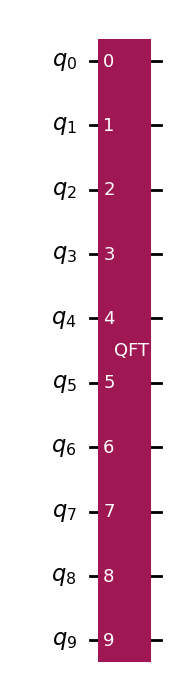

In [3]:
num_qubits=10
qc=QFT(num_qubits,do_swaps=False)
qc.draw(output="mpl")

In [4]:


def get_qc_characteristics(qc):
    depth=qc.depth()
    num_qubits=qc.num_qubits
    ops=qc.count_ops()
    num_multi_qubit_ops=qc.num_nonlocal_gates()
    return {
        "depth":depth,
        "num_qubits":num_qubits,
        "ops":ops,
        "num_multi_qubit_ops":num_multi_qubit_ops,
    }

In [5]:
def print_qc_characteristics(qc):
    characteristics = get_qc_characteristics(qc)
    print("Quantum circuit characteristics")
    print("  Depth:", characteristics['depth'])
    print("  Number of qubits:", characteristics['num_qubits'])
    print("  Operations:", dict(characteristics['ops']))
    print("  Number of multi-qubit Operations:", characteristics['num_multi_qubit_ops'])


In [6]:
print_qc_characteristics(qc)

Quantum circuit characteristics
  Depth: 1
  Number of qubits: 10
  Operations: {'QFT': 1}
  Number of multi-qubit Operations: 1


In [35]:
grade_lab1_ex1(get_qc_characteristics)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [36]:
qc_dec=qc.decompose()
get_qc_characteristics(qc_dec)
qc_dec.draw(fold=-1)

┌───┐
q_0: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────■──────────────────────────────────────■──────────────────────────────────■───────────────────────────■───────────────────────■──────────────────■─────────────■────────■───────┤ H ├
                                                                                                                                                                                                                                                                     │                                            │                                      │                                  │                           │                       │                  │       ┌───┐ │        │P(π/2) └───┘
q_1: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────■──────────┼──────────────────────────────────■─────────┼────────────────────────────■─────────┼────────────────────────■─────────┼──────────────────■────────┼──────────────■────────┼─────────■────────┼───────┤ H ├─┼────────■────────────
                                                                                                                                                                                                                   │                                      │          │                                  │         │                            │         │                        │         │                  │        │        ┌───┐ │        │         │P(π/2)  │       └───┘ │P(π/4)               
q_2: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────■─────────┼────────────────────────────■─────────┼──────────┼────────────────────────■─────────┼─────────┼───────────────────■────────┼─────────┼───────────────■────────┼─────────┼─────────■────────┼────────┼────────┤ H ├─┼────────┼─────────■────────┼─────────────■─────────────────────
                                                                                                                                                                      │                                  │         │                            │         │          │                        │         │         │                   │        │         │         ┌───┐ │        │         │         │P(π/2)  │        │        └───┘ │P(π/4)  │                  │P(π/8)                             
q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────■─────────┼────────────────────────■─────────┼─────────┼───────────────────■────────┼─────────┼──────────┼───────────────■────────┼─────────┼─────────┼──────────■────────┼────────┼─────────┼─────────┤ H ├─┼────────┼─────────┼─────────■────────┼────────┼──────────────■────────┼──────────────────■───────────────────────────────────
                                                                                                                                │                           │         │                        │         │         │                   │        │         │          │         ┌───┐ │        │         │         │          │P(π/2)  │        │         │         └───┘ │P(π/4)  │         │                  │P(π/8)  │                       │P(π/16)                                               
q_4: ─────────────────────────────────────────────────────────────────────────────────────

In [37]:
backend=GenericBackendV2(num_qubits)
print("Supported Basis Gates: ",backend.operation_names)

Supported Basis Gates:  ['cx', 'id', 'rz', 'sx', 'x', 'reset', 'delay', 'measure']


In [38]:
qc_synth=generate_preset_pass_manager(2,backend=backend).run(qc)
qc_synth.draw(fold=-1)

global phase: 0
                                                                                                                 ┌───┐   ┌───────────┐   ┌───┐    ┌──────────┐             ┌───┐  ┌──────────┐                   ┌───┐┌─────────┐                  ┌───┐┌──────────┐                   ┌───┐ ┌──────────┐┌────┐┌───────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
q_6 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ Rz(-π/16) ├───┤ X ├────┤ Rz(π/16) ├─────────────┤ X ├──┤ Rz(-π/8) ├───────────────────┤ X ├┤ Rz(π/8) ├──────────────────┤ X ├┤ Rz(-π/4) ├───────────────────┤ X ├─┤ Rz(3π/4) ├┤ √X ├┤ Rz(3.117) ├──────────────────────────────────────────────────────■───────────────────────────────────────────■───────────────────────────■──────────────────────────────────────────────■───────────────────────────────────────────■─────────────────────────────────────────────────■──────────────────────────────────■────────────────────────────────────────────────■─────────────■────────────────────────────────────────────■───────────────────────■──────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         ┌─────────┐┌────┐┌────────────┐                                                                         └─┬─┘   └───────────┘   └─┬─┘    └──────────┘             └─┬─┘  └──────────┘                   └─┬─┘└─────────┘                  └─┬─┘└──────────┘                   └─┬─┘ └──────────┘└────┘└───────────┘                                                      │                                           │                           │                                              │                                           │                                                 │                                  │                                                │             │                                            │                       │                                                  │                                                                                                                                                                                                                                                                                                                          
q_9 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.1385) ├──■────────────────■────────────────■──────────────────────────────■───────■───────────────────────■───────────■─────────────────────┼─────────■─────────■─────────────────┼───────────────■─────────────────┼────────────────■──────────────────┼───────────────────────────■─────────────────────■──────────────────────────────────────┼────────■────────■─────────────────────────┼────────■──────────────────┼────────■─────────────────────────────────────┼───────■───────────────────────────────────┼─────────────────────────────────────────────────┼──────────────────────────────────┼──────────────

In [39]:
print_qc_characteristics(qc_synth)

Quantum circuit characteristics
  Depth: 65
  Number of qubits: 10
  Operations: {'rz': 101, 'cx': 90, 'sx': 10}
  Number of multi-qubit Operations: 90


In [40]:
cm=CouplingMap.from_line(10)
qc_routed=transpile(qc,coupling_map=cm)
qc_routed.draw(fold=-1)

q_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                      │P(π/512)      │                                                                                                                                                                                         
q_1 -> 1 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────X──────■──────────────X────────────────■─────────────X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                 │P(π/256)     │                                      │P(π/256)     │                                                                                                                                                          
q_2 -> 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────X──────■─────────────X─────────────────■─────────────X──────■─────────────X────────────────■─────────────X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                            │P(π/128)     │                                      │P(π/128)     │                                     │P(π/128)     │                                                                                                                           
q_4 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────■────────────────────X───■─────────────X─────────────────■─────────────X──────■─────────────X─────────────────■────────────X──────■─────────────X───────────────■────────────X──────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                   │P(π/32)             │                                   │P(π/64)      │                                      │P(π/64)     │                                    │P(π/64)     │                                                                                              
q_3 -> 4 ────────────────────────────────────────────────────────────────────────────────────X─────■─────────■──────────X────■───────────────────────X──────■─────────────X─────────────────■─────────────X──────■────────────X─────────────────■────────────X─────■────────────X─────────■──────────X─────────────────────────────────────────────────────────────────────────
                                                                               ┌───┐         │               │P(π/64)        │P(π/16)                │                                      │P(π/32)      │                                     │P(π/32)     │                            │P(π/32)   │                                                                         
q_6 -> 5 ───────────────────────────■─────────────■──────────────────■─────────┤ H ├───X─────X───────────────■──────────X────■─────────■─────────────X──────■────────────────────────X──────■─────────────X────────────────■─────────────X──────■────────────X───────────────■─────────X──■──────────X───■────────────X─────────

In [41]:
grade_lab1_ex2(qc_routed)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [12]:
pm_staged=StagedPassManager()
pm_staged.init=generate_unroll_3q(None)
pm_staged.layout=PassManager()

pm_staged.layout+=TrivialLayout(cm)
pm_staged.layout+=generate_embed_passmanager(cm)

In [13]:
pm_staged.routing=PassManager(BasicSwap(coupling_map=cm))
qc_routed=pm_staged.run(qc)
print_qc_characteristics(qc_routed)

Quantum circuit characteristics
  Depth: 99
  Number of qubits: 10
  Operations: {'swap': 240, 'cp': 45, 'h': 10}
  Number of multi-qubit Operations: 285


In [14]:
qc_routed.draw(fold=-1)

┌───┐
q_0 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────■─────────────■─────────────■────────────■────────────■────────────■───────────■───────────■───────┤ H ├
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌───┐    │P(π/512)     │P(π/256)     │P(π/128)     │P(π/64)     │P(π/32)     │P(π/16)     │P(π/8)     │P(π/4)     │P(π/2) └───┘
q_1 -> 1 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────■─────────────■────────────■────────────■────────────■───────────■───────────■───────┤ H ├─X──■──────────X──■──────────X──■──────────X──■─────────X──■─────────X──■─────────X──■────────X──■────────X──■────────────
                                                                                                                                                                                                                                                                                                                                                                                                    ┌───┐    │P(π/256)     │P(π/128)     │P(π/64)     │P(π/32)     │P(π/16)     │P(π/8)     │P(π/4)     │P(π/2) └───┘ │             │             │             │            │            │            │           │           │               
q_2 -> 2 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────■────────────■────────────■────────────■───────────■───────────■───────┤ H ├─X──■──────────X──■──────────X──■─────────X──■─────────X──■─────────X──■────────X──■────────X──■─────────X───X──────X──────X──────X──────X──────X──────X─────X──────X─────X──────X─────X──────X─────X─────X─────X─────X───────────────
                                                                                                                                                                                                                                                                                                      ┌───┐    │P(π/128)     │P(π/64)     │P(π/32)     │P(π/16)     │P(π/8)     │P(π/4)     │P(π/2) └───┘ │             │             │            │            │            │           │           │            │          │             │             │            │            │            │            │           │                     
q_3 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────■────────────■

In [131]:
grade_lab1_ex3(pm_staged)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [15]:
basis_gates=['reset', 'id', 'rz', 'x', 'cx', 'sx', 'measure', 'delay']
pm_staged.translation=PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates)
    ]
)

In [16]:
qc_routed_synth=pm_staged.run(qc)
print_qc_characteristics(qc_routed_synth)
qc_routed_synth.draw(fold=-1)

Quantum circuit characteristics
  Depth: 897
  Number of qubits: 10
  Operations: {'rz': 1953, 'sx': 1057, 'cx': 808, 'x': 320}
  Number of multi-qubit Operations: 808


global phase: 3.9285
         ┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [166]:
grade_lab1_ex4(pm_staged)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [17]:
qk_qc=generate_preset_pass_manager(2,backend=backend).run(qc)
print_qc_characteristics(qk_qc)

Quantum circuit characteristics
  Depth: 65
  Number of qubits: 10
  Operations: {'rz': 101, 'cx': 90, 'sx': 10}
  Number of multi-qubit Operations: 90


In [18]:
def noisy_sim(qc,backend):
    return backend.run(qc.measure_all(inplace=False),shots=7*1024).result().get_counts()

own_transpiler_sim=noisy_sim(qc_routed,backend)
qiskit_transpiler_sim=noisy_sim(qk_qc,backend)
reference_sim=noisy_sim(
    transpile(qc.decompose(),backend=backend),
    BasicSimulator()
)

print("Own transpiler fidelity:: ", round(hellinger_fidelity(own_transpiler_sim, reference_sim), 4))
print("Qiskit transpiler fidelity:: ", round(hellinger_fidelity(qiskit_transpiler_sim, reference_sim), 4))

Own transpiler fidelity::  0.9232
Qiskit transpiler fidelity::  0.5881


In [194]:
isa=generate_preset_pass_manager(2,backend).run(qc)

In [19]:
pm_opt=StagedPassManager()
basis_gates=['reset', 'id', 'rz', 'x', 'cx', 'sx', 'measure', 'delay']

pm_opt.init=generate_unroll_3q(None)
pm_opt.layout=PassManager()
pm_opt.layout+=TrivialLayout(cm)

pm_opt.routing=PassManager([
    BasicSwap(coupling_map=cm)

])

pm_opt.translation=PassManager([
    Collect2qBlocks(),
    ConsolidateBlocks(basis_gates=basis_gates),
    UnitarySynthesis(basis_gates),
])

pm_opt.optimization=PassManager([
    CommutativeCancellation(),
])

pm_opt.layout+=generate_embed_passmanager(qc)
qc_opt=pm_opt.run(qc)

AttributeError: 'QFT' object has no attribute 'physical_qubits'

In [ ]:
grade_lab1_ex5(pm_opt)

In [40]:
backend=GenericBackendV2(num_qubits)

In [20]:
pm_opt=StagedPassManager()
basis_gates=['reset', 'id', 'rz', 'x', 'cx', 'sx', 'measure', 'delay']

pm_opt.init=generate_unroll_3q(None)

pm_opt.layout=PassManager()
pm_opt.layout+=TrivialLayout(cm)

pm_opt.routing=PassManager([
    StarPreRouting(),
])

pm_opt.optimization=PassManager([
    Collect2qBlocks(),
    ConsolidateBlocks(basis_gates=basis_gates),
    UnitarySynthesis(basis_gates=basis_gates),
])
pm_opt.layout+=generate_embed_passmanager(cm)
qc_opt=pm_opt.run(qc)

In [63]:
grade_lab1_ex5(pm_opt)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [21]:

print_qc_characteristics(qc_opt)
reduction_ratio = round(100-100*(get_qc_characteristics(qc_opt)['num_multi_qubit_ops']/get_qc_characteristics(qk_qc)['num_multi_qubit_ops']), 3)
print("Reduction in two-qubit gates compared to qiskit {}%!".format(reduction_ratio))
qc_opt.draw(fold=-1)

Quantum circuit characteristics
  Depth: 178
  Number of qubits: 10
  Operations: {'rz': 371, 'sx': 186, 'cx': 133, 'x': 38}
  Number of multi-qubit Operations: 133
Reduction in two-qubit gates compared to qiskit -47.778%!


global phase: 4.7139
           ┌────────┐      ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ┌───┐    ┌─────────┐                  ┌───┐    ┌────────────┐    ┌───┐     ┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
q_0 -> 0 ──┤ Rz(-π) ├──────┤ √X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├────┤ Rz(π/2) ├──────────────────┤ X ├────┤ Rz(1.5677) ├────┤ X ├─────┤ Rz(π/1024) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [22]:
opt_transpiler_sim = noisy_sim(qc_opt, backend)

print("Own transpiler fidelity", round(hellinger_fidelity(own_transpiler_sim, reference_sim), 4))
print("Qiskit transpiler fidelity", round(hellinger_fidelity(qiskit_transpiler_sim, reference_sim), 4))
print("Own optimized transpiler fidelity", round(hellinger_fidelity(opt_transpiler_sim, reference_sim), 4))

Own transpiler fidelity 0.9232
Qiskit transpiler fidelity 0.5881
Own optimized transpiler fidelity 0.8914


In [42]:
class GatesPerQubit(AnalysisPass):
    def __init__(self):
        self.property_set={}
    def run(self,dag:DAGCircuit):
        one_q_op={qubit:0 for qubit in dag.qubits}
        two_q_op={qubit:0 for qubit in dag.qubits}

        for node in dag.op_nodes():
            if node.op.num_qubits==1:
                qubit=node.qargs[0]
                one_q_op[qubit]+=1
            elif node.op.num_qubits==2:
                qubit1,qubit2=node.qargs
                two_q_op[qubit1]+=1
                two_q_op[qubit2]+=1
        self.property_set['one_q_op'] = one_q_op
        self.property_set['two_q_op'] = two_q_op   

In [44]:
grade_lab1_ex6(GatesPerQubit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [9]:
pg = Gate('Peres', 3, params=[], label='PG')

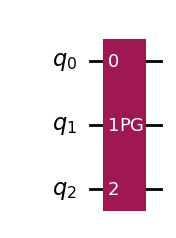

In [10]:

qc_pg = QuantumCircuit(3)
qc_pg.append(pg, [0, 1, 2])
qc_pg.draw(output="mpl")

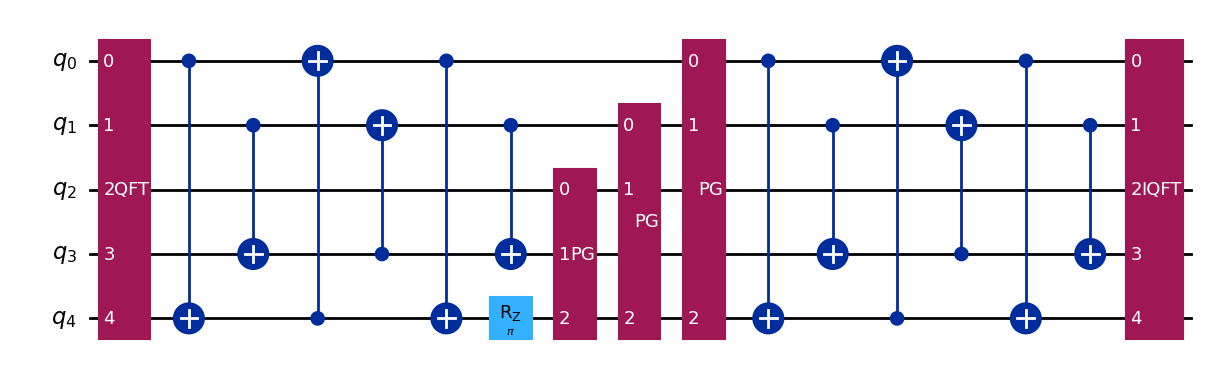

In [11]:
def get_qc_in(nq):
    qc_qft=QFT(nq,do_swaps=False)
    qc_inner=QuantumCircuit(nq)
    for i in range (1,nq-1):
        qc_inner.append(pg,[nq-i-2,nq-i-1,nq-1])
    qc_in=QuantumCircuit(nq)
    qc_in.compose(qc_qft,range(nq),inplace=True)

    for i in range(nq // 2):       
        qc_in.cx(i, nq - i - 1)
        qc_in.cx( nq - i - 1, i)
        qc_in.cx(i, nq - i - 1)
        
    qc_in.rz(pi, nq-1)

    qc_in.compose(qc_inner, range(nq), inplace=True)
    

    for i in range(nq // 2):
        qc_in.cx(i, nq - i - 1)
        qc_in.cx( nq - i - 1, i)
        qc_in.cx(i, nq - i - 1)
    qc_in.compose(qc_qft.inverse(), range(nq), inplace=True)
    return qc_in

nq = 5
qc_in = get_qc_in(nq)
qc_in.draw(fold=-1,output="mpl")

In [12]:
from qiskit import QuantumRegister
import numpy as np

In [16]:
class PeresGateTranslation(TransformationPass):
    def get_peres_decomposition(self):
        qcsx = QuantumCircuit(2)
        qcsx.rz(pi / 4, 0)
        qcsx.rz(pi / 2, 1)
        qcsx.sx(1)
        qcsx.rz(pi / 2, 1)
        qcsx.cx(0, 1)
        qcsx.rz(-pi / 4, 1)
        qcsx.cx(0, 1)
        qcsx.rz(3 * pi / 4, 1)
        qcsx.sx(1)
        qcsx.rz(pi / 2, 1)

        qcsx_inv = QuantumCircuit(2)
        qcsx_inv.rz(pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(-pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 2, 0)
        qcsx_inv.rz(pi / 2, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 2, 1)            
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.sx(1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(-pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 4, 0)
    
        qc_dec = QuantumCircuit(3)
        qc_dec.cx(0, 1)
        qc_dec.cx(1, 0)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.cx(1, 0)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx_inv, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.cx(0, 1)
        return qc_dec
    def run(self, dag: DAGCircuit) -> DAGCircuit:
        # Get the Peres gate decomposition circuit
        peres_decomposition = self.get_peres_decomposition()
        
        # Iterate over all the nodes in the DAG
        for node in dag.op_nodes():
            # Check if the node is a Peres gate
            if node.op.name == 'Peres':
                # Create a DAG from the Peres gate decomposition
                decomposed_dag = circuit_to_dag(peres_decomposition)
                
                # Substitute the Peres gate node with the decomposed DAG
                dag.substitute_node_with_dag(node, decomposed_dag)
                
        return dag

In [17]:
# grade your work!
grade_lab1_ex7(PeresGateTranslation, pg)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [20]:
def get_decomposed_peres():
        qcsx = QuantumCircuit(2)
        qcsx.rz(pi / 4, 0)
        qcsx.rz(pi / 2, 1)
        qcsx.sx(1)
        qcsx.rz(pi / 2, 1)
        qcsx.cx(0, 1)
        qcsx.rz(-pi / 4, 1)
        qcsx.cx(0, 1)
        qcsx.rz(3 * pi / 4, 1)
        qcsx.sx(1)
        qcsx.rz(pi / 2, 1)

        qcsx_inv = QuantumCircuit(2)
        qcsx_inv.rz(pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(-pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 2, 0)
        qcsx_inv.rz(pi / 2, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 2, 1)            
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.sx(1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(-pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 4, 0)
    
        qc_dec = QuantumCircuit(3)
        qc_dec.cx(0, 1)
        qc_dec.cx(1, 0)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.cx(1, 0)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx_inv, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.cx(0, 1)
        return qc_dec

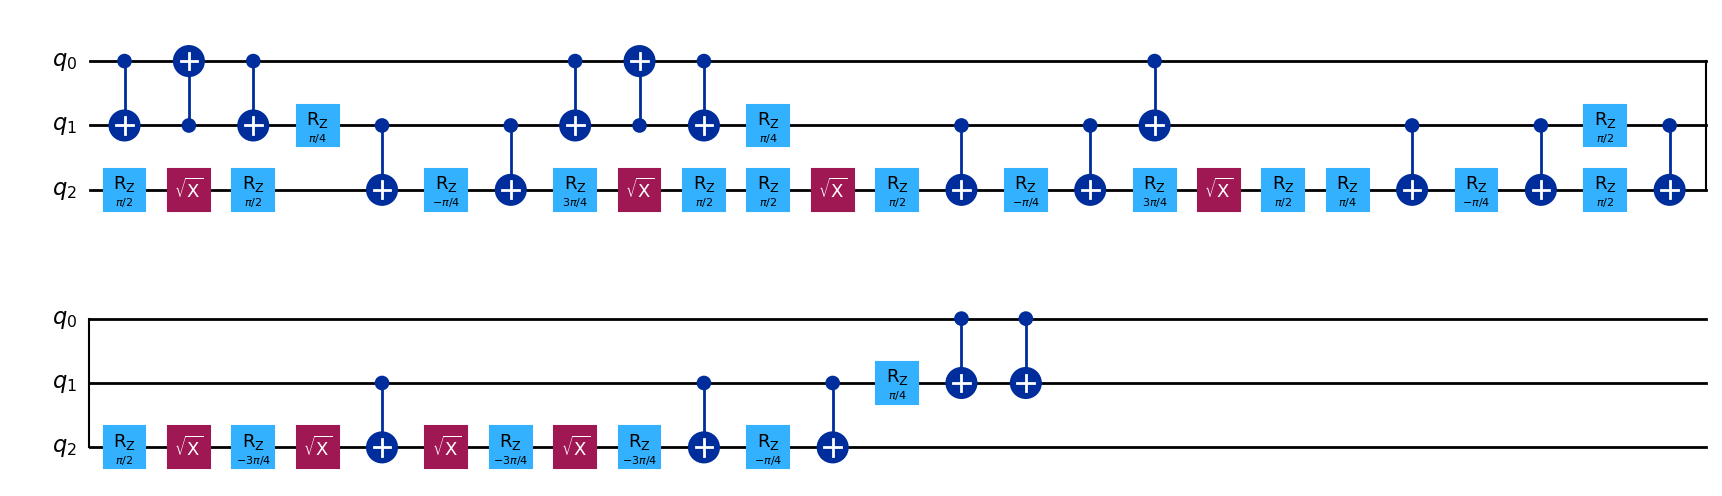

In [21]:
qc_decomposed_peres=get_decomposed_peres()
qc_decomposed_peres.draw(output="mpl")

In [22]:
print_qc_characteristics(qc_decomposed_peres)

Quantum circuit characteristics
  Depth: 40
  Number of qubits: 3
  Operations: {'rz': 22, 'cx': 19, 'sx': 8}
  Number of multi-qubit Operations: 19


In [26]:
dag=DAGCircuit()
peres_decomposition = get_decomposed_peres()
        
        # Iterate over all the nodes in the DAG
for node in dag.op_nodes():
            # Check if the node is a Peres gate
    if node.op.name == 'Peres':
                # Create a DAG from the Peres gate decomposition
        decomposed_dag = circuit_to_dag(peres_decomposition)
                
                # Substitute the Peres gate node with the decomposed DAG
        dag.substitute_node_with_dag(node, decomposed_dag)
